# EDA and Cleaning

## Project Intro

- Problem Statement: Using machine learning models, can we predict if a given borrower is going to default on their loan payment?

- Value Add: Spotting prospective borrowers with high financial uncertainty will help firms manage their credit risk. Lenders will have a better idea as to who is most likely to default and stop that loan from being accepted in the first place.

- Data Used: LendingClub accepted loan from 2007 to 2020

## Notebook Intro

This is the first notebook in a total of 3.

In this notebook we will be:
1. Conducting Exploratory Data Analysis
2. Removing any columns that have redundant, bad, or future data
3. Cleaning all NULL values

### General Imports

In [1]:
import re
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

## Load Data

Let's Read in both the accepted and rejected loan csv's into Pandas Data Frames:

In [3]:
accepted = pd.read_csv('accepted.csv')
rejected = pd.read_csv('rejected.csv')

## EDA

Data Dictionary: https://www.kaggle.com/datasets/jonchan2003/lending-club-data-dictionary

Now that we have loaded all required data, let's take a look at the size of each data frame:

In [4]:
print(accepted.shape)
print(rejected.shape)

(2260701, 151)
(27648741, 9)


We are dealing with a considerable amount of data here. We have a little over 2 million accepted loans and close to 28 million rejected loans. To get more information on the features we have available, we can take a look at the first 5 rows of each data frame.

In [5]:
accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [6]:
rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


Looking at the datasets, we only need accepted loans to predict whether a loan is going to be default or not. The goal is to take previously defaulted loans and see if we can find out what features they have in common. We can also see that there is a large number of NULL values in the accepted loans data. 

## Columns with Over 10% Null Values

As we previously saw that we might have a large number of NULL values, our first step is going to be to drop any columns that have over 10% NULL values in them. This will reduce the number of features that we have, both making EDA easier and running code snippets faster. Let's take a look at the total number of NULL values that we are going to have to clean:

In [7]:
print(accepted.isna().sum().sum())

108486249


We have over 100 million NULL values to deal with. Let's drop our columns first and then compare this number to the amount of NULL values we have left. In the following cell, we are finding the percentage of NULL values in each column and creating a new data frame.

In [8]:
percent_missing_a = accepted.isnull().sum() * 100 / len(accepted)
missing_values_a = pd.DataFrame({'column_name': accepted.columns,
                                 'percent_missing': percent_missing_a})

In [9]:
missing_values_a.sort_values(by=['percent_missing'], ascending=False).head(30)

,column_name,percent_missing
member_id,member_id,100.000000
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.617331
hardship_end_date,hardship_end_date,99.517097
hardship_start_date,hardship_start_date,99.517097
hardship_type,hardship_type,99.517097
hardship_reason,hardship_reason,99.517097
hardship_status,hardship_status,99.517097
deferral_term,deferral_term,99.517097
hardship_last_payment_amount,hardship_last_payment_amount,99.517097
hardship_payoff_balance_amount,hardship_payoff_balance_amount,99.517097


As you can see, there are 30+ columns that have over 95% NULL values in them. We also have plenty others with over 10%. In this next cell, we are dropping any feature with over 10%.

In [10]:
nan_percentage_a = accepted.isna().mean() * 100
columns_to_drop_a = nan_percentage_a[nan_percentage_a > 10].index.tolist()
accepted_cleaner = accepted.drop(columns=columns_to_drop_a)

In [11]:
accepted_cleaner.shape

(2260701, 92)

After dropping the features with high NULL values, we have gone from 151 to 92 columns.

In [12]:
print(accepted_cleaner.isna().sum().sum())

2734063


Compared to before when we had over 100 million NULL values, we now have around 3 million to deal with.

## Duplicates

Before we move on to EDA, let's check for any duplicated rows in our data:

In [13]:
accepted_cleaner.duplicated().sum()

0

We have no duplicated rows and can move on to more in depth analysis.

## Write Cleaner Data to a CSV

In [14]:
# Write accepted_cleaner to csv
accepted_cleaner.to_csv('accepted_cleaner.csv', index=False)

In [15]:
# read in accepted_cleaner
accepted_cleaner = pd.read_csv('accepted_cleaner.csv')

## Target `loan_status` Column Processing

The first step in our EDA is to look at our target column, `loan_status` and redistribute the values into "Paid" and "Defualt". Our target is going to be a binary column. Let's take a look at the unique values in our target feature:

https://help.lendingclub.com/hc/en-us/articles/216109367-What-Do-the-Different-Note-Statuses-Mean-

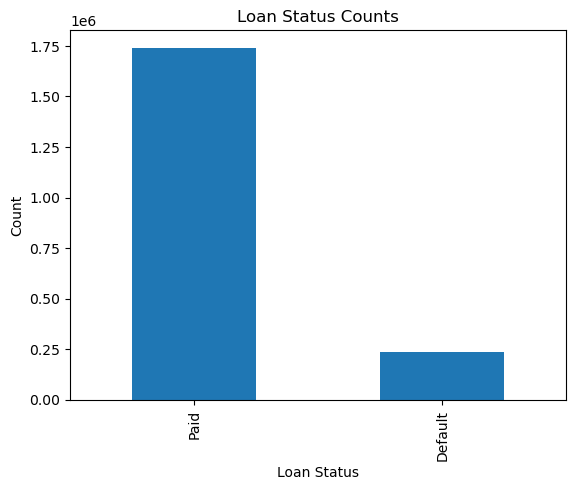

In [98]:
accepted_cleaner['loan_status'].value_counts().plot(kind='bar')
plt.title("Loan Status Counts")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

Looking at the results, we can see that we have 9 different outcomes, but we can group them into "Paid", "Late" and "Default". We can do this by using a `mapper`.

In [17]:
# map loan status to 3 categories
status_mapper = {
    'Fully Paid': 'Paid',
    'Current': 'Paid',
    'Charged Off': 'Default', 
    'Late (31-120 days)': 'Late',
    'In Grace Period': 'Late', 
    'Late (16-30 days)': 'Late', 
    'Does not meet the credit policy. Status:Fully Paid': 'Paid',
    'Does not meet the credit policy. Status:Charged Off': 'Default',
    'Default': 'Default'
}

In [18]:
# apply mapper to loan status
accepted_cleaner['loan_status'] = accepted_cleaner['loan_status'].map(status_mapper)

In [19]:
# new loan status counts
accepted_cleaner['loan_status'].value_counts()

Paid       1957056
Default     269360
Late         34252
Name: loan_status, dtype: int64

After applying our mapper to our target column, we now have three outcomes for a loan. However, for our project, we are only interested in either Paid or Default Loans. We can get rid of the Late loans now.

In [20]:
# keep only paid and default loans
accepted_cleaner = accepted_cleaner[ (accepted_cleaner["loan_status"]== "Paid") | (accepted_cleaner["loan_status"]== "Default")]

Let's plot out the distribution of our target feature to see the balance of the data:

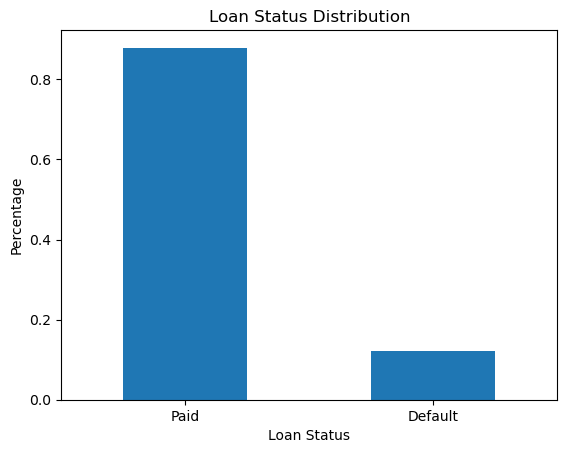

In [21]:
# plot percentage of loan status
accepted_cleaner['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Percentage')
# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='center')
plt.show()
    

Looking at the graph, we have a very imbalanced dataset. Over 80% of our data lies in the Paid loans outcome. When we get to modeling, we are most likely going to have to downsample the Paid loans based on the results that we get.

## EDA on Redundant Columns

Our first step in EDA is going to be looking at any columns that might have redundant data in them. This means that two features might be telling us the same information but in two different ways. There is no reason to have both columns in our modeling as they will have high correlation with eachother.

In [22]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3

### Grade vs Sub Grade

The first set of columns that we can immediately notice is `grade` and `sub_grade`. At first glance it looks like `sub_grade` is a more detailed version of `grade`. 

*Data Dictionary*

- Grade: LC assigned loan grade
- SubGrade: LC assigned loan subgrade
- Grades are assigned to indicated the expected risk of the loan. A grade of "A" means lowest expected risk of loss and a grade of "G" means highest expected risk of loss.

Let's take a look at the values in each of these features:

In [23]:
accepted_cleaner['grade'].value_counts()

B    656005
C    638030
A    430732
D    316795
E    132272
F     40791
G     11791
Name: grade, dtype: int64

In [24]:
accepted_cleaner['sub_grade'].value_counts().sort_values()

G5      1508
G4      1650
G3      2030
G2      2612
G1      3991
F5      5006
F4      5975
F3      7599
F2      9112
F1     13099
E5     21932
E4     22181
E3     25986
E2     29269
E1     32904
D5     46722
D4     55559
D3     63189
A2     69234
D2     71271
A3     72772
D1     80054
A1     86526
A4     95280
A5    106920
C5    114059
B1    124171
C4    124461
B2    125407
C3    126878
C2    128951
B3    130150
B4    138028
B5    138249
C1    143681
Name: sub_grade, dtype: int64

Our above assumption is correct. Before deciding which column we would like to drop, lets compare `grade` and `sub_grade` by the number of values corresponding to each letter. This will let us know if all values in `sub_grade` match up to their respective letter in `grade`. We are going to do this for "A".

In [25]:
# sum values in sub_grade that start with 'A'
print(accepted_cleaner['sub_grade'].str.startswith('A').sum())

# values in grade that start with 'A'
print(accepted_cleaner['grade'].str.startswith('A').sum())

430732
430732


All values starting with "A" in `sub_grade` match up to the number of values in `grade`. If we think ahead to when we need to process these columns, we are going to have to find a way to convert them into a numerical value. This will be much easier if we use `grade` vs `sub_grade` so we are going to drop `sub_grade`.

In [26]:
# drop sub_grade
accepted_cleaner.drop(columns=['sub_grade'], inplace=True)

### Purpose vs Title

The next two features that seem to have redundant data are `purpose` and `title`. 

*Data Dictionary*

- Purpose: A category provided by the borrower for the loan request.
- Title: The loan title provided by the borrower

Let's take a look at the values in each of these features:

In [27]:
# value counts for purpose
accepted_cleaner['purpose'].value_counts()

debt_consolidation    1257882
credit_card            510465
home_improvement       148133
other                  136956
major_purchase          49582
medical                 27039
small_business          24168
car                     23716
vacation                15301
moving                  15123
house                   13846
wedding                  2355
renewable_energy         1426
educational               424
Name: purpose, dtype: int64

In [28]:
# value counts for title
accepted_cleaner['title'].value_counts()

Debt consolidation             1133602
Credit card refinancing         463279
Home improvement                135136
Other                           125244
Major purchase                   43981
                                ...   
Debt Consolifation                   1
Life Perserver Loan                  1
NeverAgain                           1
Consolidate 3 loans                  1
debt reduction/hone updates          1
Name: title, Length: 63153, dtype: int64

Looking at the two columns, it seems that `purpose` is a given list of categories on the loan application and `title` is a handwritten section by the borrower. Since `purpose` is a list of categories, we only have 14 different values while we have over 60,000 in `title`. We are going to drop `title` from our data.

In [29]:
# drop title
accepted_cleaner.drop(columns=['title'], inplace=True)

## EDA on Bad Data

Next, we are going to take a look at any columns that seem to have data that will not be helpful in our prediction. This could be data that is not written correctly in the columns or features that have predominantly one value in the column.

In [30]:
accepted_cleaner.head(20)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.000,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.000,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.000,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.000,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,

### URL

One of the columns that look to have data that will not be useful is `url`. This columns looks to contain only a list of website links. Let's look at the values in this column:

*Data Dictionary*
- URL: URL of the listing on LendingClub.com

In [31]:
# value counts for url
accepted_cleaner['url'].value_counts()

https://lendingclub.com/browse/loanDetail.action?loan_id=68407277     1
https://lendingclub.com/browse/loanDetail.action?loan_id=134675222    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134912584    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134873443    1
https://lendingclub.com/browse/loanDetail.action?loan_id=133471368    1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=140960946    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140968809    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140567619    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140777381    1
https://lendingclub.com/browse/loanDetail.action?loan_id=88215728     1
Name: url, Length: 2226416, dtype: int64

We have a link for each loan that brings you to the Lending Club website. This link will not be useful in modeling so we will drop the column.

In [32]:
# drop url
accepted_cleaner.drop(columns=['url'], inplace=True)

### pymnt_plan

Payment plan looks to have all the same value so let's dive further into that column.

*Data Dictionary*
- pymnt_plan: Indicates if a payment plan has been put in place for the loan

Let's take a look at the values in this feature:

In [33]:
# value counts for pymnt_plan
accepted_cleaner['pymnt_plan'].value_counts()

n    2226413
y          3
Name: pymnt_plan, dtype: int64

We can see that all values except for 3 are "n". Having all values be the same will not assist our model in differentiating between the loan outcomes. We are going to drop this column.

In [34]:
# drop pymnt_plan
accepted_cleaner.drop(columns=['pymnt_plan'], inplace=True)

### zip_code

Looking at the zip code column, we have the first 3 digits and then the last two are filled with 'x'. We can see if this is true for every loan.

*Data Dictionary*
- zip_code: The first 3 numbers of the zip code provided by the borrower in the loan application.

The data only shows the first 3 numbers to protect privacy. Let's take a look at the number of values in this column but we are most likely going to have to drop it.

In [35]:
# value counts for zip_code
accepted_cleaner['zip_code'].value_counts()

945xx    23457
112xx    23437
750xx    23306
606xx    20917
300xx    20180
         ...  
520xx        1
521xx        1
849xx        1
872xx        1
858xx        1
Name: zip_code, Length: 956, dtype: int64

We have close to 1000 unique zip codes and since they are not complete, we will not be able to use them. We can now drop this column.

In [36]:
# drop zip_code
accepted_cleaner.drop(columns=['zip_code'], inplace=True)

### hardship_flag

This feature seem to have a Y or N but all values look the same.

*Data Dictionary*
- hardship_flag: Flags whether or not the borrower is on a hardship plan

Let's take a look at the value counts for this column:

In [37]:
# value counts for hardship_flag
accepted_cleaner['hardship_flag'].value_counts()

N    2226412
Y          4
Name: hardship_flag, dtype: int64

All values except 4 are "N" so we are going to drop this column.

In [38]:
# drop hardship_flag
accepted_cleaner.drop(columns=['hardship_flag'], inplace=True)

### policy_code

Policy code looks to have majority of the same value to let's dive further into this column.

*Data Dictionary*
- policy_code: publicly available policy_code=1

In [39]:
# value counts for policy_code
accepted_cleaner['policy_code'].value_counts()

1.0    2226416
Name: policy_code, dtype: int64

All of the values in this column are the same so we can go ahead and drop it.

In [40]:
# drop policy_code
accepted_cleaner.drop(columns=['policy_code'], inplace=True)

## EDA on Future Data

The next part of our EDA is going to be to look at any columns that have data in the future. This means any data that has been recorded after the loan was issued. As we are trying to predict is a loan is going to default before getting accepted, these columns will induce data leakage into our models.

In [41]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Paid,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Paid,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Paid,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Paid,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Paid,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash,N


### debt_settlement_flag

*Data Dictionary*
- debt_settlement_flag: Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.

This column only comes into play after the borrow has achieved the "charged_off" status. This is not useful in our model.

In [42]:
# value counts for debt_settlement_flag
accepted_cleaner['debt_settlement_flag'].value_counts()

N    2193096
Y      33320
Name: debt_settlement_flag, dtype: int64

We are going to drop this column.

In [43]:
# drop debt_settlement_flag
accepted_cleaner.drop(columns=['debt_settlement_flag'], inplace=True)

### last_credit_pull_d and issue_d

*Data Dictionary*
- last_credit_pull_d: The most recent month LC pulled credit for this loan
- issue_d: The month and year which the loan was funded

Since this column has the most recent date that the borrower pulled credit for their loan, this is after the loan has been started. This column will not help us in our predictions. To check this, we can convert the column to datetime, extract the year from the column and compare it to the year of the `issue_d` column, which has the year that the loan was issued.

In [44]:
# convert issue_d to datetime
accepted_cleaner['issue_d'] = pd.to_datetime(accepted_cleaner['issue_d'])

# get year from issue_d
accepted_cleaner['issue_d_year'] = accepted_cleaner['issue_d'].dt.year

# convert last_credit_pull_d to datetime
accepted_cleaner['last_credit_pull_d'] = pd.to_datetime(accepted_cleaner['last_credit_pull_d'])

# get year from last_credit_pull_d
accepted_cleaner['last_credit_pull_d_year'] = accepted_cleaner['last_credit_pull_d'].dt.year

Here we are creating a new column that shows us the difference of the previous two columns.

In [45]:
# subtract last_credit_pull_d_year from issue_d_year
accepted_cleaner['issue_to_pull'] = accepted_cleaner['last_credit_pull_d_year'] - accepted_cleaner['issue_d_year']

In [46]:
# value counts for issue_to_pull
accepted_cleaner['issue_to_pull'].value_counts()

 1.0     615542
 2.0     544612
 3.0     494999
 4.0     285946
 5.0     139286
 6.0      60565
 0.0      49937
 7.0      21208
 8.0       7993
 9.0       3870
 10.0      1485
 11.0       661
 12.0       133
-1.0         99
-2.0          7
-3.0          1
Name: issue_to_pull, dtype: int64

We can see that the majority of dates are after the issue date of the loan. We can drop `last_credit_pull_d` from our data.

In [47]:
# drop issue_d, last_credit_pull_d, last_credit_pull_d_year, issue_to_pull
accepted_cleaner.drop(columns=['issue_d', 'last_credit_pull_d', 'last_credit_pull_d_year', 'issue_to_pull'], inplace=True)

### last_pymnt_d

Similar to last credit pull date, this column also seems to have future data.

*Data Dictionary*
- last_pymnt_d: Last month payment was received

We can convert this column to datetime and then subtract the year from the issue date to check if it is a future data column or not.

In [48]:
# convert last_pymnt_d to datetime
accepted_cleaner['last_pymnt_d'] = pd.to_datetime(accepted_cleaner['last_pymnt_d'])

# get year from last_pymnt_d
accepted_cleaner['last_pymnt_d_year'] = accepted_cleaner['last_pymnt_d'].dt.year

# subtract last_pymnt_d_year from issue_d_year
accepted_cleaner['issue_to_pymnt'] = accepted_cleaner['last_pymnt_d_year'] - accepted_cleaner['issue_d_year']

# show value counts for issue_to_pymnt
accepted_cleaner['issue_to_pymnt'].value_counts()

1.0    865573
2.0    596433
3.0    486775
0.0    176882
4.0     70006
5.0     28002
6.0       420
Name: issue_to_pymnt, dtype: int64

We can see here that all years in `last_pymnt_date` are also after the original issue date of the loan. We will have to drop this column.

In [49]:
# drop last_pymnt_d, last_pymnt_d_year, issue_to_pymnt
accepted_cleaner.drop(columns=['last_pymnt_d', 'last_pymnt_d_year', 'issue_to_pymnt'], inplace=True)

### out_prncp and out_prncp_inv

*Data Dictionary*
- out_prncp: Remaining outstanding principal for total amount funded
- out_prncp_inv: Remaining outstanding principal for portion of total amount funded by investors

Both of these columns are based on the remaining payment left on the principal of the loan. This is future data so we will have to drop these columns

In [50]:
# drop out_prncp and out_prncp_inv
accepted_cleaner.drop(columns=['out_prncp', 'out_prncp_inv'], inplace=True)

In [51]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_d_year
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Paid,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash,2015
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Paid,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,Cash,2015
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Paid,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,704.0,700.0,0.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,Cash,2015
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Paid,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,679.0,675.0,0.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,Cash,2015
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Paid,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,704.0,700.0,0.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash,2015


### funded_amnt and funded_amnt_inv

*Data Dictionary*
- funded_amnt: The total amount committed to that loan at that point in time.
- funded_amnt_inv: The total amount committed by investors for that loan at that point in time.

Similar to the columns above, both of these features are calculated as the payments are going on, not before the loan is accepted. Since this is future data, we will be dropping these columns

In [52]:
# drop funded_amnt_inv and funded_amnt
accepted_cleaner.drop(columns=['funded_amnt_inv', 'funded_amnt'], inplace=True)

### last_pymnt_amnt

*Data Dictionary*
- last_pymnt_amnt: Last total payment amount received

This feature is the last payment that was recieved regarding paying back the loan. Since this is future data, we will be dropping this column.

In [53]:
# drop last_pymnt_amnt
accepted_cleaner.drop(columns=['last_pymnt_amnt'], inplace=True)

### total_pymnt, total_pymnt_inv, total_rec_int, total_rec_prncp, total_rec_late_fee

*Data Dictionary*
- total_pymnt: Payments received to date for total amount funded
- total_pymnt_inv: Payments received to date for portion of total amount funded by investors
- total_rec_prncp: Principal received to date
- total_rec_int: Interest received to date
- total_rec_late_fee: Late fees received to date

All 5 of these columns deal with the total amount of money recieved to date on the current loan. This is future data, so we will have to drop all of these columns.

In [54]:
# drop total_pymnt, total_pymnt_inv, total_rec_int, total_rec_prncp, total_rec_late_fee
accepted_cleaner.drop(columns=['total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_prncp', 'total_rec_late_fee'], inplace=True)

In [55]:
accepted_cleaner.shape

(2226416, 72)

Now that we have gotten rid of 20 features that have bad data or data that will not assist us in our predictions, we can move on to cleaning the rest of the NULL values.

## Split into Categorical and Numerical

Before we get into cleaning the rest of the NULL values from our data, we are going to perform a chi-square test on our categorical columns. This will tell us if there is any significant correlation between each column and our target column. First, we are going to split our data into a numerical and categorical data frames.

In [56]:
accepted_cleaner.dtypes.value_counts()

float64    57
object     14
int64       1
dtype: int64

After splitting, we can see that we have 13 categorical columns and 58 numerical columns that are mostly in floats. Lets take a look at the first 5 rows of each of these data frames.

In [57]:
categorical_df = accepted_cleaner.select_dtypes('object').copy()
categorical_df.head()

,id,term,grade,emp_title,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,earliest_cr_line,initial_list_status,application_type,disbursement_method
0,68407277,36 months,C,leadman,10+ years,MORTGAGE,Not Verified,Paid,debt_consolidation,PA,Aug-2003,w,Individual,Cash
1,68355089,36 months,C,Engineer,10+ years,MORTGAGE,Not Verified,Paid,small_business,SD,Dec-1999,w,Individual,Cash
2,68341763,60 months,B,truck driver,10+ years,MORTGAGE,Not Verified,Paid,home_improvement,IL,Aug-2000,w,Joint App,Cash
3,66310712,60 months,C,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Paid,debt_consolidation,NJ,Sep-2008,w,Individual,Cash
4,68476807,60 months,F,Contract Specialist,3 years,MORTGAGE,Source Verified,Paid,major_purchase,PA,Jun-1998,w,Individual,Cash


In [58]:
numerical_df = accepted_cleaner.select_dtypes('float64', 'int64').copy()
numerical_df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.0,0.0,564.0,560.0,0.0,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.0,0.0,699.0,695.0,0.0,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.0,0.0,704.0,700.0,0.0,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,0.0,0.0,679.0,675.0,0.0,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.0,0.0,704.0,700.0,0.0,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0


## Chi-Square between columns and `loan status`

Now that we have our categorical columns into thier own data frame, we can perform the chi square test. This test will help us get rid of any remaining columns that we do not need to spend the time cleaning further.

In [59]:
# import chi2_contingency
from scipy.stats import chi2_contingency

target_variable = 'loan_status'

for column in categorical_df.columns:
    if column != target_variable:
        
        contingency_table = pd.crosstab(categorical_df[column], categorical_df[target_variable])

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-square test for {column} vs {target_variable}: chi2={chi2}, p-value={p_value}")

Chi-square test for id vs loan_status: chi2=2226416.0000000023, p-value=0.49968490560951634
Chi-square test for term vs loan_status: chi2=16715.613585185638, p-value=0.0
Chi-square test for grade vs loan_status: chi2=116943.39863641646, p-value=0.0
Chi-square test for emp_title vs loan_status: chi2=586441.9919945797, p-value=0.0
Chi-square test for emp_length vs loan_status: chi2=669.6711966323332, p-value=2.027991715063674e-137
Chi-square test for home_ownership vs loan_status: chi2=6189.086448745866, p-value=0.0
Chi-square test for verification_status vs loan_status: chi2=20432.596984314674, p-value=0.0
Chi-square test for purpose vs loan_status: chi2=5736.725730738217, p-value=0.0
Chi-square test for addr_state vs loan_status: chi2=3298.8574525683352, p-value=0.0
Chi-square test for earliest_cr_line vs loan_status: chi2=4301.638454978651, p-value=0.0
Chi-square test for initial_list_status vs loan_status: chi2=11179.796589155618, p-value=0.0
Chi-square test for application_type vs l

The results of our test show that we can drop `id` from our data as it has a high p-value. We are going to drop this column from both our categorical and accepted_cleaner data frames.

In [60]:
categorical_df = categorical_df.drop(columns=['id'], axis=1)
accepted_cleaner = accepted_cleaner.drop(columns=['id'], axis=1)

In [61]:
accepted_cleaner.shape

(2226416, 71)

Our resulting total data frame has 71 columns remaining.

## Remainder of Null Values 

Now that we have the least number of columns possible, we can go on to cleaning the remainder of our NULL values.

In [62]:
print(accepted_cleaner.isna().sum().sum())

2693917


We have about 2.7 million NULL values in our data. Let's splice out all rows that contain a NUL value into another data frame.

In [63]:
# find all rows with a null value
null_rows = accepted_cleaner[accepted_cleaner.isnull().any(axis=1)]
null_rows

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_d_year
19,8650.0,36 months,19.89,320.99,E,Program Coordinator,8 years,RENT,55000.0,Verified,Paid,debt_consolidation,IN,25.49,0.0,Mar-2005,675.0,679.0,4.0,18.0,1.0,9568.0,46.0,19.0,w,0.0,0.0,639.0,635.0,0.0,Individual,0.0,0.0,18926.0,20750.0,17.0,1051.0,1375.0,45.0,0.0,0.0,129.0,95.0,0.0,0.0,0.0,8.0,0.0,2.0,17.0,2.0,2.0,2.0,17.0,17.0,13.0,18.0,NaN,0.0,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0,Cash,2015
55,24000.0,60 months,9.80,507.58,B,NaN,NaN,OWN,77900.0,Not Verified,Paid,home_improvement,TN,10.24,0.0,Oct-1982,740.0,744.0,1.0,9.0,0.0,3454.0,10.3,21.0,w,0.0,0.0,814.0,810.0,0.0,Individual,0.0,0.0,127412.0,33600.0,1.0,14157.0,27172.0,10.9,0.0,0.0,139.0,398.0,22.0,22.0,2.0,22.0,1.0,2.0,3.0,4.0,6.0,6.0,7.0,13.0,3.0,9.0,0.0,0.0,0.0,0.0,95.2,0.0,0.0,0.0,202351.0,4910.0,30500.0,33631.0,Cash,2015
75,1500.0,36 months,6.49,45.97,A,NaN,NaN,MORTGAGE,45000.0,Not Verified,Paid,vacation,HI,16.11,0.0,Dec-1987,745.0,749.0,0.0,12.0,0.0,3717.0,21.2,37.0,w,0.0,0.0,739.0,735.0,0.0,Individual,0.0,0.0,158643.0,17500.0,8.0,15864.0,8818.0,27.7,0.0,0.0,123.0,336.0,6.0,3.0,4.0,6.0,0.0,1.0,3.0,4.0,15.0,8.0,9.0,25.0,3.0,12.0,0.0,0.0,0.0,4.0,97.2,0.0,0.0,0.0,179105.0,18400.0,12200.0,18050.0,Cash,2015
86,15000.0,36 months,10.78,489.52,B,Coaching General Manager,1 year,RENT,40000.0,Verified,Paid,credit_card,TX,10.17,0.0,Oct-2006,670.0,674.0,0.0,7.0,0.0,12272.0,75.3,9.0,w,0.0,0.0,724.0,720.0,0.0,Individual,0.0,0.0,12272.0,16300.0,2.0,2045.0,347.0,96.6,0.0,0.0,NaN,110.0,3.0,3.0,0.0,3.0,0.0,4.0,6.0,4.0,4.0,0.0,7.0,9.0,6.0,7.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,16300.0,12272.0,10300.0,0.0,Cash,2015
93,15000.0,36 months,5.32,451.73,A,NaN,NaN,RENT,80000.0,Not Verified,Paid,debt_consolidation,VA,20.18,0.0,Apr-1993,775.0,779.0,1.0,30.0,0.0,41593.0,21.4,47.0,w,0.0,0.0,799.0,795.0,0.0,Individual,0.0,0.0,330562.0,194800.0,6.0,13773.0,114609.0,4.2,0.0,0.0,141.0,272.0,2.0,2.0,2.0,2.0,0.0,7.0,12.0,12.0,19.0,6.0,28.0,39.0,12.0,30.0,0.0,0.0,0.0,2.0,97.9,0.0,0.0,0.0,537200.0,97129.0,119600.0,94400.0,Cash,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260681,24000.0,60 months,12.79,543.50,C,TMSG,10+ years,RENT,63000.0,Verified,Paid,debt_consolidation,FL,19.73,1.0,Oct-2005,670.0,674.0,0.0,10.0,0.0,19845.0,47.0,23.0,f,0.0,0.0,704.0,700.0,1.0,Individual,0.0,159.0,35214.0,41850.0,3.0,3521.0,5800.0,57.0,0.0,0.0,131.0,125.0,7.0,7.0,2.0,17.0,0.0,4.0,9.0,5.0,5.0,6.0,9.0,15.0,7.0,10.0,NaN,0.0,1.0,1.0,100.0,0.0,0.0,0.0,65648.0,35214.0,23200.0,23798.0,Cash,2016
2260683,30000.0,60 months,9.49,629.91,B,NaN,NaN,MORTGAGE,110000.0,Verified,Paid,medical,FL,10.20,1.0,May-1993,745.0,749.0,0.0,10.0,0.0,25899.0,33.8,22.0,f,0.0,0.0,664.0,660.0,0.0,Individual,0.0,0.0,159038.0,80400.0,3.0,15904.0,42192.0,36.1,0.0,0.0,11

We have around 380 thousand rows that contain NULL values.

### Rows with all Null 

Let's first check if there are any rows that contain a NULL value in any column.

In [64]:
accepted_cleaner.isnull().all(axis=1).sum()

0

We have no rows consisting of all NULL values.

Now we can go through each column individually and find out how many NULL values they have.

In [65]:
accepted_cleaner.isnull().sum(axis = 0).sort_values(ascending = False)

emp_title                     163774
num_tl_120dpd_2m              151579
emp_length                    144020
mo_sin_old_il_acct            137884
bc_util                        75573
percent_bc_gt_75               74900
bc_open_to_buy                 74458
mths_since_recent_bc           72972
pct_tl_nvr_dlq                 70431
avg_cur_bal                    70345
mo_sin_old_rev_tl_op           70277
num_rev_accts                  70277
mo_sin_rcnt_rev_tl_op          70277
num_tl_90g_dpd_24m             70276
num_rev_tl_bal_gt_0            70276
tot_coll_amt                   70276
num_bc_tl                      70276
num_tl_30dpd                   70276
tot_cur_bal                    70276
total_rev_hi_lim               70276
num_il_tl                      70276
mo_sin_rcnt_tl                 70276
num_actv_rev_tl                70276
num_accts_ever_120_pd          70276
num_tl_op_past_12m             70276
total_il_high_credit_limit     70276
tot_hi_cred_lim                70276
n

We can see that we have many columns with the same number of NULL values in them. We can take some of these columns and see if the indexes of the NULL values match up.

### Rows with 70276 null values

There are 16 columns that have 70276 null values so lets look at a few of these columns and see if the indicies are the same.

In [66]:
col1 = accepted_cleaner[accepted_cleaner['tot_coll_amt'].isnull()].index.tolist()
col2 = accepted_cleaner[accepted_cleaner['tot_cur_bal'].isnull()].index.tolist()
col3 = accepted_cleaner[accepted_cleaner['total_rev_hi_lim'].isnull()].index.tolist()
col4 = accepted_cleaner[accepted_cleaner['mo_sin_rcnt_tl'].isnull()].index.tolist()
col5 = accepted_cleaner[accepted_cleaner['num_accts_ever_120_pd'].isnull()].index.tolist()
col6 = accepted_cleaner[accepted_cleaner['num_actv_bc_tl'].isnull()].index.tolist()
col7 = accepted_cleaner[accepted_cleaner['num_actv_rev_tl'].isnull()].index.tolist()
col1==col2==col3==col4==col5==col6==col7

True

All the indexes of the NULL values match up so we can go ahead and drop those rows.

In [67]:
accepted_cleaner = accepted_cleaner.drop(index=accepted_cleaner[accepted_cleaner['tot_coll_amt'].isnull()].index.tolist(), columns='tot_coll_amt')

In [68]:
accepted_cleaner.isnull().sum(axis = 0).sort_values(ascending = False)

emp_title                     159436
emp_length                    141959
num_tl_120dpd_2m               81303
mo_sin_old_il_acct             67608
bc_util                        25259
percent_bc_gt_75               24599
bc_open_to_buy                 24157
mths_since_recent_bc           22703
dti                             1673
revol_util                      1643
pct_tl_nvr_dlq                   155
avg_cur_bal                       69
mo_sin_old_rev_tl_op               1
mo_sin_rcnt_rev_tl_op              1
inq_last_6mths                     1
num_rev_accts                      1
pub_rec_bankruptcies               0
num_bc_sats                        0
disbursement_method                0
total_il_high_credit_limit         0
mo_sin_rcnt_tl                     0
mort_acc                           0
total_bc_limit                     0
num_accts_ever_120_pd              0
num_actv_bc_tl                     0
num_actv_rev_tl                    0
num_bc_tl                          0
t

In [69]:
accepted_cleaner.isna().sum().sum()

550568

Just by dropping those rows, we have gone from 2.7 million NULL values to around 550 thousand.

### Employment Title

*Data Dictionary*
- emp_title: The job title supplied by the Borrower when applying for the loan.

The next column with the most NULL values is Employment Length. Lets splice out the rows where there is a NULL value.

In [70]:
accepted_cleaner[accepted_cleaner['emp_title'].isna()]

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_d_year
55,24000.0,60 months,9.80,507.58,B,NaN,NaN,OWN,77900.0,Not Verified,Paid,home_improvement,TN,10.24,0.0,Oct-1982,740.0,744.0,1.0,9.0,0.0,3454.0,10.3,21.0,w,0.0,0.0,814.0,810.0,0.0,Individual,0.0,127412.0,33600.0,1.0,14157.0,27172.0,10.9,0.0,0.0,139.0,398.0,22.0,22.0,2.0,22.0,1.0,2.0,3.0,4.0,6.0,6.0,7.0,13.0,3.0,9.0,0.0,0.0,0.0,0.0,95.2,0.0,0.0,0.0,202351.0,4910.0,30500.0,33631.0,Cash,2015
75,1500.0,36 months,6.49,45.97,A,NaN,NaN,MORTGAGE,45000.0,Not Verified,Paid,vacation,HI,16.11,0.0,Dec-1987,745.0,749.0,0.0,12.0,0.0,3717.0,21.2,37.0,w,0.0,0.0,739.0,735.0,0.0,Individual,0.0,158643.0,17500.0,8.0,15864.0,8818.0,27.7,0.0,0.0,123.0,336.0,6.0,3.0,4.0,6.0,0.0,1.0,3.0,4.0,15.0,8.0,9.0,25.0,3.0,12.0,0.0,0.0,0.0,4.0,97.2,0.0,0.0,0.0,179105.0,18400.0,12200.0,18050.0,Cash,2015
93,15000.0,36 months,5.32,451.73,A,NaN,NaN,RENT,80000.0,Not Verified,Paid,debt_consolidation,VA,20.18,0.0,Apr-1993,775.0,779.0,1.0,30.0,0.0,41593.0,21.4,47.0,w,0.0,0.0,799.0,795.0,0.0,Individual,0.0,330562.0,194800.0,6.0,13773.0,114609.0,4.2,0.0,0.0,141.0,272.0,2.0,2.0,2.0,2.0,0.0,7.0,12.0,12.0,19.0,6.0,28.0,39.0,12.0,30.0,0.0,0.0,0.0,2.0,97.9,0.0,0.0,0.0,537200.0,97129.0,119600.0,94400.0,Cash,2015
139,25000.0,36 months,7.49,777.55,A,NaN,NaN,MORTGAGE,132000.0,Not Verified,Paid,debt_consolidation,MI,13.83,0.0,Aug-1974,745.0,749.0,1.0,14.0,0.0,33231.0,48.0,32.0,w,0.0,0.0,734.0,730.0,0.0,Individual,0.0,78666.0,69200.0,6.0,5619.0,22487.0,53.2,0.0,0.0,77.0,496.0,19.0,1.0,3.0,19.0,0.0,1.0,3.0,4.0,10.0,11.0,9.0,17.0,4.0,14.0,0.0,0.0,0.0,3.0,100.0,50.0,0.0,0.0,137788.0,50636.0,48100.0,30190.0,Cash,2015
141,2500.0,36 months,11.48,82.42,B,NaN,NaN,RENT,16488.0,Not Verified,Paid,debt_consolidation,CT,38.06,0.0,Nov-2005,770.0,774.0,1.0,12.0,0.0,2469.0,8.2,18.0,w,0.0,0.0,684.0,680.0,0.0,Individual,0.0,20449.0,30100.0,5.0,2045.0,18432.0,11.4,0.0,0.0,121.0,104.0,18.0,8.0,0.0,20.0,0.0,1.0,2.0,4.0,6.0,5.0,8.0,11.0,2.0,12.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,51341.0,20449.0,20800.0,21241.0,Cash,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260650,16000.0,60 months,12.79,362.34,C,NaN,NaN,OWN,105000.0,Source Verified,Paid,debt_consolidation,CT,15.41,1.0,May-1977,680.0,684.0,0.0,10.0,0.0,11240.0,23.5,37.0,f,0.0,0.0,694.0,690.0,0.0,Individual,1.0,21488.0,47900.0,4.0,2388.0,26065.0,17.0,0.0,0.0,161.0,472.0,17.0,1.0,6.0,17.0,0.0,3.0,5.0,4.0,14.0,8.0,7.0,21.0,5.0,10.0,0.0,1.0,0.0,2.0,97.3,25.0,0.0,0.0,68726.0,21488.0,31400.0,20826.0,Cash,2016
2260679,22000.0,60 months,13.99,511.79,C,NaN,NaN,RENT,93600.0,Not Verified,Paid,debt_consolidation,VA,11.42,0.0,Jan-1985,720.0,724.0,0.0,8.0,0.0,12269.0,63.6,14.0,f,0.0,0.0,704.0,700.0,0.0,Joint App,0.0,37326.0,19300.0,5.0,4666.0,5756.0,67.3,0.0,0.0,128.0,380.0,15.0,14.0,0.0,21.0,0.0,6.0,7.0,6.0,7.0,

We can see that many rows have NULL values in both Employment Title and Employment Length. Let's find those indexes and drop those rows.


In [71]:
# common indexes
employment = accepted_cleaner[(accepted_cleaner['emp_title'].isnull()) & (accepted_cleaner['emp_length'].isnull())].index.tolist()

# length of common indexes
len(employment)

141256

There are over 140 thousand rows that have NULL values in both columns. As one of these features is the most likely factor in filling in the other, we can go ahead and drop these rows.

In [72]:
# drop rows with common indexes
accepted_cleaner = accepted_cleaner.drop(employment)

In [74]:
# null in emp_title
accepted_cleaner['emp_title'].isnull().sum()

18180

Now we have 18 thousand NULL values left in `emp_title`. Let's look at the values in this column to see if we can fill in the rest.

In [75]:
# value counts for emp_title
accepted_cleaner['emp_title'].value_counts()

Teacher                           38292
Manager                           33693
Owner                             21394
Registered Nurse                  15622
RN                                14517
                                  ...  
Sr. Admin. Asst                       1
Lead Food Service Coordinator         1
Event production services             1
Tire repair &sales specialist         1
Current Operations Officer            1
Name: emp_title, Length: 468747, dtype: int64

We have over 450 thousand different job titles so we can drop these rows as there is no way of knowing what to fill in. We can also drop this column because this looks to be handwritten by the applicant and converting it to numeric will be difficult.

In [76]:
# drop null in emp_title
accepted_cleaner = accepted_cleaner.dropna(subset=['emp_title'])

In [77]:
# drop emp_title
accepted_cleaner = accepted_cleaner.drop(columns=['emp_title'], axis=1)

### Columns that refer to Bankcard accounts 

There might be many rows with null values in both `bc_open_to_buy` and `bc_util` as they are both referring to bankcards.

*Data Dictionary*
- bc_open_to_buy: Total open to buy on revolving bankcards.
- bc_util: Ratio of total current balance to high credit/credit limit for all bankcard accounts.

In [78]:
bankcards = accepted_cleaner[(accepted_cleaner['bc_open_to_buy'].isnull())&(accepted_cleaner['bc_util'].isnull())].index.tolist()
len(bankcards)

21425

Since there are null values in both of these columns, we can drop these rows.

In [79]:
accepted_cleaner = accepted_cleaner.drop(bankcards)

In [80]:
accepted_cleaner.isnull().sum(axis = 0).sort_values(ascending = False)

num_tl_120dpd_2m              75827
mo_sin_old_il_acct            55471
bc_util                        1022
emp_length                      696
percent_bc_gt_75                384
revol_util                      210
pct_tl_nvr_dlq                  142
mths_since_recent_bc             98
dti                              91
inq_last_6mths                    1
num_rev_accts                     1
mo_sin_rcnt_rev_tl_op             0
mo_sin_rcnt_tl                    0
mort_acc                          0
mo_sin_old_rev_tl_op              0
num_il_tl                         0
num_accts_ever_120_pd             0
num_actv_bc_tl                    0
num_actv_rev_tl                   0
delinq_amnt                       0
num_bc_sats                       0
num_bc_tl                         0
loan_amnt                         0
num_op_rev_tl                     0
num_rev_tl_bal_gt_0               0
chargeoff_within_12_mths          0
num_tl_30dpd                      0
num_tl_90g_dpd_24m          

### Months since oldest installment account

Next, we can take a look at `mo_sin_old_il_acct`

*Data Dictionary*
- mo_sin_old_il_acct: Months since oldest bank installment account opened

In [81]:
accepted_cleaner['mo_sin_old_il_acct'].nunique()

548

In [82]:
accepted_cleaner['mo_sin_old_il_acct'].value_counts().sort_values(ascending=False).head(10)

130.0    22577
127.0    22425
128.0    22358
129.0    22358
132.0    22283
133.0    22274
125.0    22272
134.0    22255
126.0    22251
131.0    22131
Name: mo_sin_old_il_acct, dtype: int64

The value counts in this column look to be spread pretty evenly so we can use a forward fill to fill in the NULL values. Using this method will not disturb the distribution. 

In [83]:
# forwards fill the null values in mo_sin_old_il_acct
accepted_cleaner['mo_sin_old_il_acct'].fillna(method='ffill', inplace=True)

In [84]:
accepted_cleaner['mo_sin_old_il_acct'].value_counts().sort_values(ascending=False).head(10)

130.0    23184
129.0    23057
127.0    23053
128.0    22981
132.0    22920
126.0    22906
134.0    22902
133.0    22901
125.0    22896
131.0    22732
Name: mo_sin_old_il_acct, dtype: int64

As you can see, we have the same top 10 as we did before.

### Number of accounts ever 120 days past due

Another column with a large amount of NULL values is `num_tl_120dpd_2m`.

*Data Dictionary*
- num_tl_120dpd_2m: Number of accounts currently 120 days past due (updated in past 2 months)

In [85]:
accepted_cleaner['num_tl_120dpd_2m'].nunique()

7

We have 7 unique values in this feature so let's take a look at the value counts for each.

In [86]:
accepted_cleaner['num_tl_120dpd_2m'].value_counts()

0.0    1898279
1.0       1122
2.0         43
3.0          5
6.0          1
7.0          1
4.0          1
Name: num_tl_120dpd_2m, dtype: int64

There are very few entries that have 1 or more accounts ever past 120 days, so to keep the rest of the rows, we are going to fill in 0 for the null values.

In [87]:
accepted_cleaner['num_tl_120dpd_2m'] = accepted_cleaner['num_tl_120dpd_2m'].fillna(0)

In [88]:
accepted_cleaner.isnull().sum(axis = 0).sort_values(ascending = False)

bc_util                       1022
emp_length                     696
percent_bc_gt_75               384
revol_util                     210
pct_tl_nvr_dlq                 142
mths_since_recent_bc            98
dti                             91
num_rev_accts                    1
inq_last_6mths                   1
num_actv_bc_tl                   0
num_il_tl                        0
num_bc_tl                        0
num_bc_sats                      0
num_actv_rev_tl                  0
mo_sin_old_rev_tl_op             0
mo_sin_old_il_acct               0
num_op_rev_tl                    0
delinq_amnt                      0
mort_acc                         0
mo_sin_rcnt_tl                   0
mo_sin_rcnt_rev_tl_op            0
num_accts_ever_120_pd            0
loan_amnt                        0
num_rev_tl_bal_gt_0              0
chargeoff_within_12_mths         0
num_tl_120dpd_2m                 0
num_tl_30dpd                     0
num_tl_90g_dpd_24m               0
num_tl_op_past_12m  

We have very little NULL values remaining in our data. 

### Rest of Null Values

Let's sum up the remaining NULL values and see what percentage of the total data they take up.

In [90]:
accepted_cleaner.isnull().sum().sum()

2645

In [91]:
accepted_cleaner.shape

(1975279, 69)

In [92]:
# percentage of null values to total rows
accepted_cleaner.isnull().sum().sum()/accepted_cleaner.shape[0]

0.001339051344139233

The remaining null values take up 0.1% of our data so we are just going to drop all of the rows.

Let's find the indexes where these NULL values are.

In [93]:
lastnull = accepted_cleaner[accepted_cleaner.isnull().any(axis=1)].index.tolist()

Now that we have a list of the indexes, we can drop these rows from our data. We are going to rename this data to "nonnull" to save to a CSV later.

In [94]:
accepted_nonull = accepted_cleaner.drop(lastnull)

Sanity check on the number of NULL values remaining.

In [95]:
accepted_nonull.isnull().sum().sum()

0

We have cleaned our data of NULL values and can now reset the index and save this into a new CSV.

In [96]:
# reset index
accepted_nonull = accepted_nonull.reset_index(drop=True)

In [97]:
# save non-null data to csv
accepted_nonull.to_csv('accepted_nonull.csv', index=False)

Our data is now fully clean and we can now move onto processing the categorical columns into numerical columns. This is going to be done in the next notebook.